# Evaluation
* In this notebook, we compute the initial BLEU score matrices & discuss alignment
* First, we compute scores directly on the translations, assuming that DeepL & GPT4.1 preserved the alignment.
* We then identify the pairs we suspect to be misaligned, `out_lines!=400` and re-compute the scores using aligned versions of them.
    * Evaluation was a work-in-progress task but we decided to align based on how sentences were provied by the datasets; so without sentence splitting
    * If sentence splitting is applied, it can lead to loss of sentences, giving a false sense of improved quality. 

In [1]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager
parts = {
    'opus': {'dm':Opus100Manager(), 'pairs':Opus100Manager.get_pairs()},
    'ep': {'dm':EuroParlManager(), 'pairs':EuroParlManager.get_pairs()},
    'flores': {'dm':FloresPlusManager(), 'pairs':FloresPlusManager.get_pairs()}
}

translators = ['gpt', 'deepl']

In [2]:
from scripts.post_process import direct_triplet_align, load_sents_from_file
fn2align_cnt_direct = {}
for dataset, content in parts.items():
    dm = content['dm']
    pairs = content['pairs']
    for pair in pairs:
        s, t = pair
        for translator in translators:
            filename = f'{dataset}-{translator}-{s}-{t}'
            mt_sents = load_sents_from_file(
                folder='translations', filename=filename)
            src_sents, tgt_sents = dm.get_sentence_pairs(
                s, t, num_of_sents=400)
            cnt = direct_triplet_align(
                mt_sents=mt_sents,
                src_sents=src_sents,
                ref_sents=tgt_sents,
                folder_path='direct_triplets',
                filename=filename
            )
            fn2align_cnt_direct[filename] = cnt

In [ ]:
from scripts.scoring import ResultProducer
import os
from os.path import join

files = os.listdir('direct_triplets')
os.makedirs('direct_results', exist_ok=True)

cases = ['ep-gpt', 'ep-deepl', 'flores-gpt',
                'flores-deepl', 'opus-gpt', 'opus-deepl']

for case in cases:
    l2f = {f.replace(f'{case}-', '').replace('.jsonl', '')
                     : join('direct_triplets', f) for f in files if f.startswith(case)}
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('direct_results', f'{case}.csv'))

ep-deepl


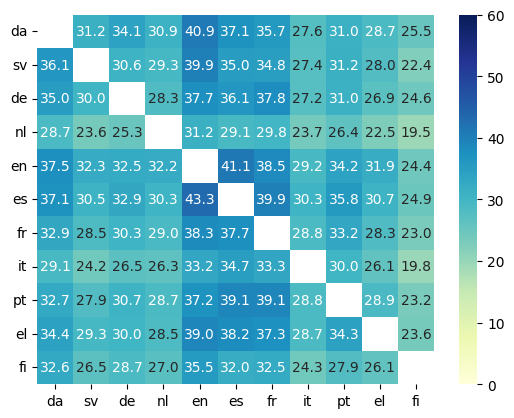


ep-gpt


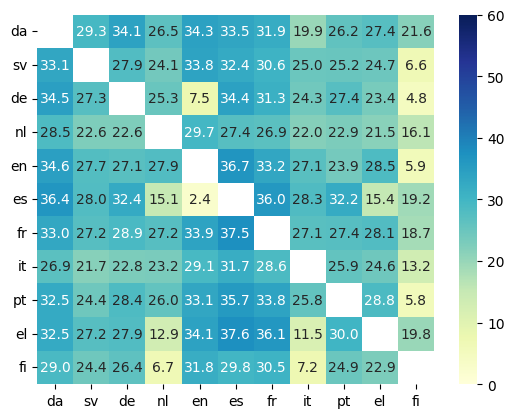


flores-deepl


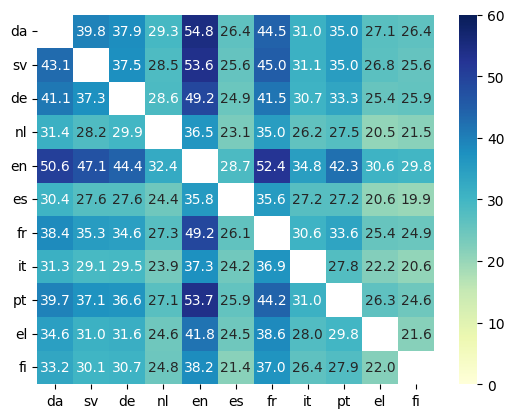


flores-gpt


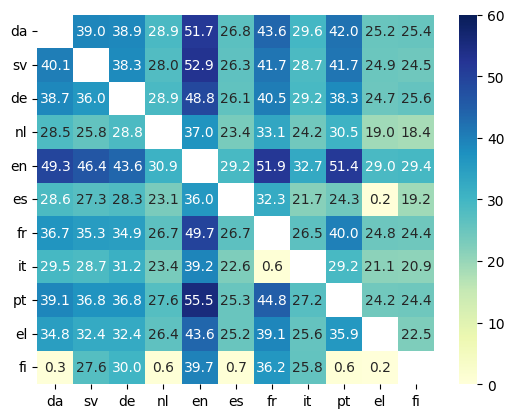


opus-deepl


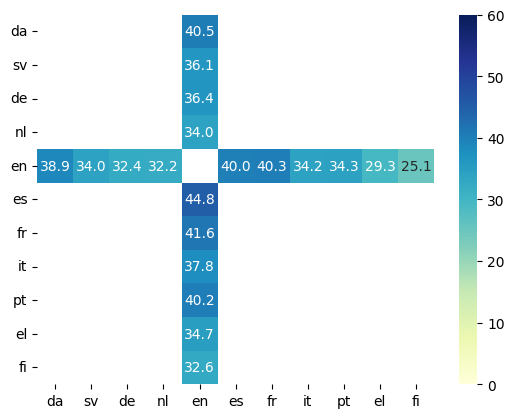


opus-gpt


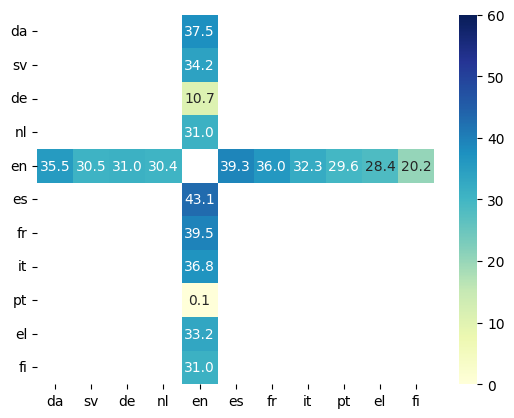

In [3]:
from scripts.presentation import Presenter
p1 = Presenter(results_folder='direct_results')
p1.show_score_matrices()

* Now we check the scores of the pairs that we suspect to be misaligned.

In [4]:
from os.path import join
import json
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

mismatches = {
    'ep-gpt': [],
    'flores-gpt': [],
    'opus-gpt': [],
}

mismatch_outlines = {}

for prefix, info in prefix2file.items():
    dataset, translator, s, t = prefix.split('-')
    key = f'{dataset}-{translator}'
    outlines = info['log']['out_lines']
    if outlines != 400:
        score = p1.fi2df[key]['BLEU'].loc[s, t]
        mismatches[key].append((f'{s}-{t}', score))
        mismatch_outlines[prefix] = outlines

for key in mismatches:
    print(key)
    for item in sorted(mismatches[key], key=lambda x: x[1], reverse=True):
        label, score = item
        print(f'{label}: {score:.2f}')
    print()

ep-gpt
da-it: 19.91
es-el: 15.40
es-nl: 15.05
it-fi: 13.18
el-nl: 12.86
el-it: 11.54
de-en: 7.48
fi-it: 7.24
fi-nl: 6.73
sv-fi: 6.63
en-fi: 5.88
pt-fi: 5.85
de-fi: 4.77
es-en: 2.42

flores-gpt
fi-es: 0.65
it-fr: 0.62
fi-nl: 0.60
fi-pt: 0.59
fi-da: 0.29
es-el: 0.23
fi-el: 0.22

opus-gpt
de-en: 10.74
pt-en: 0.11



* Furthermore, we check all pairs below 20 that are seen as mismatches.

In [5]:
further = {}
for key in p1.fi2df:
    df = p1.fi2df[key]['BLEU']
    stack = df.stack()
    if key in mismatches:
        mismatch = set([o[0] for o in mismatches[key]])
    else:
        mismatch = set()
    lower_than_20 = stack[stack < 20]
    lower_than_20 = [(f'{src}-{tgt}', bleu) for (src, tgt), bleu in lower_than_20.items()
                     if f'{src}-{tgt}' not in mismatch]
    if len(lower_than_20) > 0:
        further[key] = lower_than_20

for key in further:
    print(key)
    for item in sorted(further[key], key=lambda x: x[1], reverse=True):
        label, score = item
        print(f'\t{label}: {score:.2f}')
    print()

ep-deepl
	it-fi: 19.83
	nl-fi: 19.46

ep-gpt
	el-fi: 19.82
	es-fi: 19.21
	fr-fi: 18.71
	nl-fi: 16.07

flores-deepl
	es-fi: 19.91

flores-gpt
	es-fi: 19.25
	nl-el: 18.98
	nl-fi: 18.38



* So we have now a set of pairs that we suspect have BLEU scores due to misalignment
* We apply alignment for these pairs using the pre-existing split, so we do not make `bertalign` apply sentence splitting.

## Fixed Evaluation

* Off-screen, we applied alignment to all sentences but for evaluation, we try to apply it only if it is necessary, since alignment can lead to loss of sentences.

In [6]:
from scripts.post_process import post_triplet_align, load_aligned_sents_from_file
import os
src2hyp_split_fo = 'source2translations_without_sent_split'
filenames = [f.replace('.jsonl', '') for f in os.listdir(src2hyp_split_fo)]

In [7]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager

dms = {
    'ep': EuroParlManager(),
    'flores': FloresPlusManager(),
    'opus': Opus100Manager()
}

fn2align_cnt_fixed = {}
fn2discard = {}
cases = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']
case2align_cnts = {c: [] for c in cases}

for fn in filenames:
    dataset, translator, s, t = fn.split('-')
    src_sents_a, mt_sents_a = load_aligned_sents_from_file(
        fn, folder=src2hyp_split_fo)
    dm = dms[dataset]
    src_sents_o, ref_sents_o = dm.get_sentence_pairs(s, t, num_of_sents=400)
    align_cnt, dis = post_triplet_align(
        src_sents_org=src_sents_o,
        src_sents_ali=src_sents_a,
        ref_sents_org=ref_sents_o,
        mt_sents_ali=mt_sents_a,
        folder_path='post_triplets_without_sent_split',
        filename=fn)

    fn2align_cnt_fixed[fn] = align_cnt
    fn2discard[fn] = dis
    case2align_cnts[f'{dataset}-{translator}'].append(align_cnt)


for t, ac in case2align_cnts.items():
    max_cnt = max(ac)
    min_cnt = min(ac)
    mean = sum(ac) / len(ac)
    print(t)
    print(f'min: {min_cnt}')
    print(f'max: {max_cnt}')
    print(f'mean: {mean:.2f}')
    print()

ep-gpt
min: 383
max: 398
mean: 396.31

ep-deepl
min: 369
max: 398
mean: 395.77

flores-gpt
min: 394
max: 400
mean: 398.83

flores-deepl
min: 394
max: 400
mean: 398.79

opus-gpt
min: 372
max: 400
mean: 397.85

opus-deepl
min: 395
max: 400
mean: 398.70



* We observe that for at least on language pair, this alignment led to 400 sentences becomes 310.

In [8]:
import os
from os.path import join
files = os.listdir('direct_triplets')
cases = ['ep-gpt', 'ep-deepl', 'flores-gpt', 'flores-deepl', 'opus-gpt', 'opus-deepl']
case_l2f = {}
for case in cases:
    l2f = {f.replace(f'{case}-', '').replace('.jsonl', ''):join('direct_triplets', f) for f in files if f.startswith(case)}
    case_l2f[case] = l2f

In [9]:
to_be_fixed = {k:[] for k in list(mismatches.keys())+list(further.keys())}
for key in mismatches:
    for item in mismatches[key]:
        pair = item[0]
        to_be_fixed[key].append(pair)
        
for key in further:
    for item in further[key]:
        pair = item[0]
        to_be_fixed[key].append(pair)

In [10]:
for case in to_be_fixed:
    fix_pairs = to_be_fixed[case]
    for pair in fix_pairs:
        case_l2f[case][pair] = join(
            'post_triplets_without_sent_split', f'{case}-{pair}.jsonl')

In [ ]:
from scripts.scoring import ResultProducer
os.makedirs('fixed_results', exist_ok=True)
for case in case_l2f:
    l2f = case_l2f[case]
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('fixed_results', f'{case}.csv'))

ep-deepl


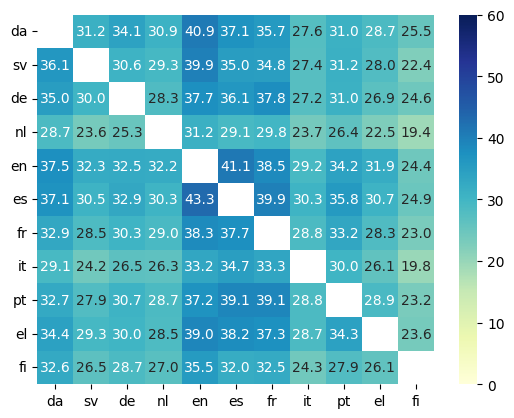


ep-gpt


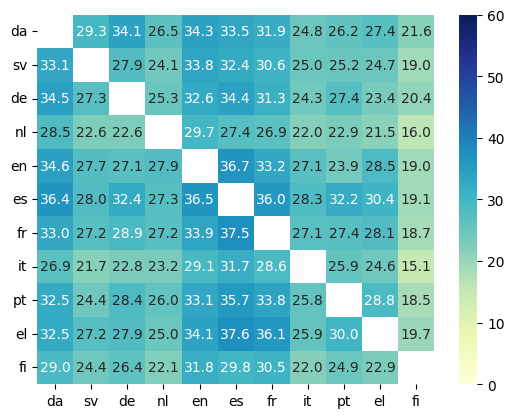


flores-deepl


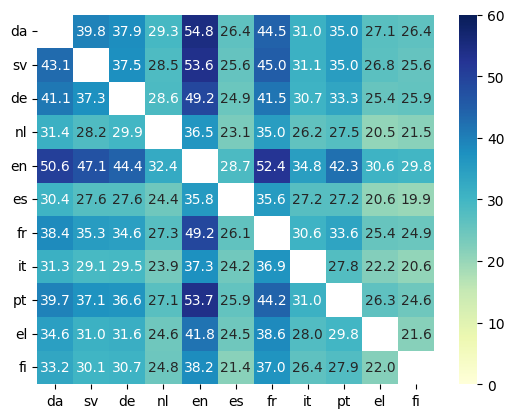


flores-gpt


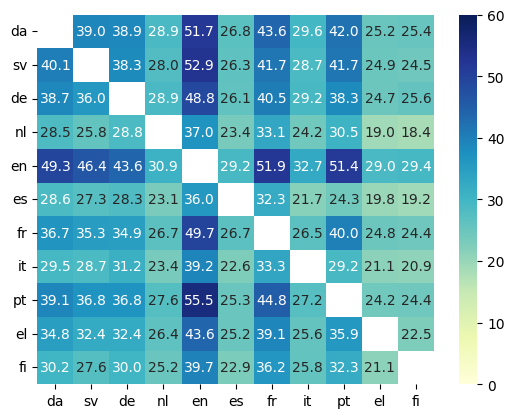


opus-deepl


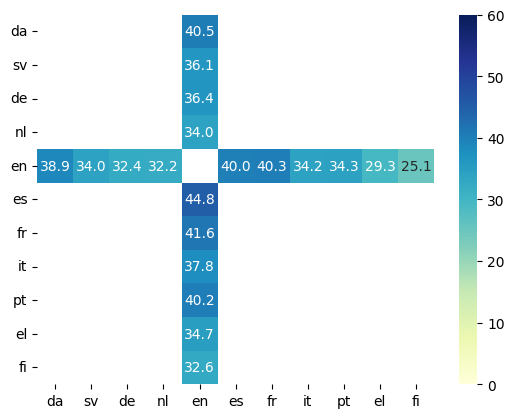


opus-gpt


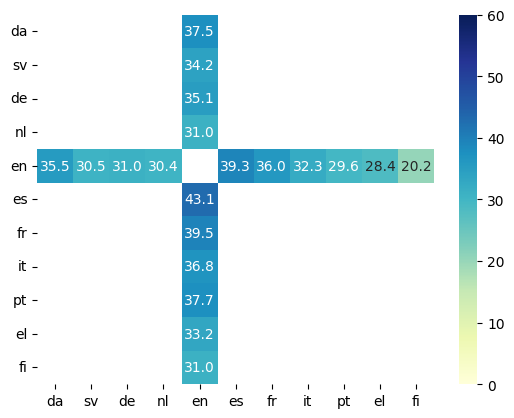

In [11]:
from scripts.presentation import Presenter
p2 = Presenter(results_folder='fixed_results')
p2.show_score_matrices()

In [12]:
mismatch_set = []
for key in mismatches:
    print(key)
    for item in sorted(mismatches[key], key=lambda x: x[1], reverse=True):
        label, score = item
        mismatch_set.append(f'{key}-{label}')
        old_outlines = fn2align_cnt_direct[f'{key}-{label}']
        new_outlines = fn2align_cnt_fixed[f'{key}-{label}']
        s, t = label.split('-')
        new_score = p2.fi2df[key]['BLEU'].loc[s, t]
        print(f'\t{label}: {score:.1f}->{new_score:.1f}')
        print(f'\t{label}: {old_outlines}->{new_outlines}')
        print()
    print()
mismatch_set = set(mismatch_set)

ep-gpt
	da-it: 19.9->24.8
	da-it: 399->396

	es-el: 15.4->30.4
	es-el: 399->395

	es-nl: 15.1->27.3
	es-nl: 399->395

	it-fi: 13.2->15.1
	it-fi: 399->395

	el-nl: 12.9->25.0
	el-nl: 399->395

	el-it: 11.5->25.9
	el-it: 399->396

	de-en: 7.5->32.6
	de-en: 398->394

	fi-it: 7.2->22.0
	fi-it: 399->394

	fi-nl: 6.7->22.1
	fi-nl: 399->395

	sv-fi: 6.6->19.0
	sv-fi: 399->394

	en-fi: 5.9->19.0
	en-fi: 400->397

	pt-fi: 5.8->18.5
	pt-fi: 400->397

	de-fi: 4.8->20.4
	de-fi: 399->394

	es-en: 2.4->36.5
	es-en: 399->397


flores-gpt
	fi-es: 0.7->22.9
	fi-es: 399->400

	it-fr: 0.6->33.3
	it-fr: 399->400

	fi-nl: 0.6->25.2
	fi-nl: 399->400

	fi-pt: 0.6->32.3
	fi-pt: 399->400

	fi-da: 0.3->30.2
	fi-da: 399->398

	es-el: 0.2->19.8
	es-el: 399->400

	fi-el: 0.2->21.1
	fi-el: 399->400


opus-gpt
	de-en: 10.7->35.1
	de-en: 372->372

	pt-en: 0.1->37.7
	pt-en: 399->400




* As desired, alignment only led to minimal loss in text with huge improvements, so we can contribute the imporvement in BLEU score to alignments.

In [13]:
for key in further:
    print(key)
    for item in sorted(further[key], key=lambda x: x[1], reverse=True):
        label, score = item
        new_outlines = fn2align_cnt_fixed[f'{key}-{label}']
        s, t = label.split('-')
        new_score = p2.fi2df[key]['BLEU'].loc[s, t]
        print(f'{label}: {score:.1f}->{new_score:.1f}')
        print(f'{label}: 400->{new_outlines}')
        print()
    print()

ep-deepl
it-fi: 19.8->19.8
it-fi: 400->397

nl-fi: 19.5->19.4
nl-fi: 400->397


ep-gpt
el-fi: 19.8->19.7
el-fi: 400->398

es-fi: 19.2->19.1
es-fi: 400->395

fr-fi: 18.7->18.7
fr-fi: 400->397

nl-fi: 16.1->16.0
nl-fi: 400->397


flores-deepl
es-fi: 19.9->19.9
es-fi: 400->400


flores-gpt
es-fi: 19.2->19.2
es-fi: 400->400

nl-el: 19.0->19.0
nl-el: 400->400

nl-fi: 18.4->18.4
nl-fi: 400->400




* As for cases where BLEU scores were particularly low, alignments did not change the score.
* Again, it is possible to "raise" the scores if we use sentence splitting but it becomes harder to contribute the improvement in score to alignment as sentence splitting can lead to further loss of sentences.


## Final Results
* To obtain the final results, we basically repeat what we have done in in Fixed Results section but this time only use alignment where required.

In [18]:
import os
from os.path import join
import shutil
direct_files = os.listdir('direct_triplets')

os.makedirs('final_triplets', exist_ok=True)
for fn in direct_files:
    name = fn.replace('.jsonl', '')
    if name not in mismatch_set:
        src_file = join('direct_triplets', fn)
    else:
        src_file = join('post_triplets_without_sent_split', fn)
        
    dst_file = join('final_triplets', fn)
    shutil.copy(src_file, dst_file)

In [19]:
from scripts.scoring import ResultProducer
cases = ['ep-gpt', 'ep-deepl', 'flores-gpt',
         'flores-deepl', 'opus-gpt', 'opus-deepl']

os.makedirs('final_results', exist_ok=True)
for case in cases:
    l2f = {f.replace(f'{case}-', '').replace('.jsonl', ''): join('final_triplets', f) for f in files if f.startswith(case)}
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('final_results', f'{case}.csv'))